In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imageio import imread

import sys

sys.path.insert(0, "../")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction

utils.plot_settings()  # LaTeX fonts in Plots!

FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

In [2]:
spacing=100 # Try 100, or try 40
max_degree=20
n_lambdas=30
k_folds=5
n_bootstraps=100
do_boot= False
do_subset= False

np.random.seed(2018)
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data

terrain_data = imread("../../datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:spacing, :1801:spacing]  # Make square and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

lambdas = np.logspace(-6, 0, n_lambdas)
subset_lambdas = np.logspace(-6, 0, 7)

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

# Centering
z_intercept = np.mean(z)
z = z - z_intercept

z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

##### Setup of problem is completede above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.

    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Probably should not have this.

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 # Probably actually not
    #    X_test_scaled[:,0] = 1 # Have a bad feeling about how this might affect ridge/lasso.

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree.

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    if do_boot:
        # All regression bootstraps at once

        lamb_ridge = best_ridge_lambda[degree_index]
        lamb_lasso = best_lasso_lambda[degree_index]

        (
            ridge_mse,
            ridge_bias,
            ridge_variance,
            lasso_mse,
            lasso_bias,
            lasso_variance,
            ols_mse,
            ols_bias,
            ols_variance,
        ) = bootstrap.bootstrap_all(
            X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
        )

        (
            ridge_best_lambda_boot_mse[degree_index],
            ridge_best_lambda_boot_bias[degree_index],
            ridge_best_lambda_boot_variance[degree_index],
        ) = (ridge_mse, ridge_bias, ridge_variance)

        (
            lasso_best_lambda_boot_mse[degree_index],
            lasso_best_lambda_boot_bias[degree_index],
            lasso_best_lambda_boot_variance[degree_index],
        ) = (lasso_mse, lasso_bias, lasso_variance)

        ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
            ols_mse,
            ols_bias,
            ols_variance,
        )

    if do_subset:
        # Bootstrapping for a selection of lambdas for ridge and lasso
        subset_lambda_index = 0
        for lamb in subset_lambdas:

            (
                ridge_mse,
                ridge_bias,
                ridge_variance,
                lasso_mse,
                lasso_bias,
                lasso_variance,
            ) = bootstrap.bootstrap_ridge_lasso(
                X_train_scaled,
                X_test_scaled,
                z_train,
                z_test,
                n_bootstraps,
                lamb_lasso,
                lamb_ridge,
            )

            (
                ridge_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (ridge_mse, ridge_bias, ridge_variance)

            (
                lasso_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (lasso_mse, lasso_bias, lasso_variance)

            subset_lambda_index += 1


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5353558.9536396675, tolerance: 2185.4665667858594
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4731848.3084766455, tolerance: 1980.017960968685
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5504176.184325287, tolerance: 2131.289841024087
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3491883.765192235, tolerance: 1980.017960968685
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4416547.168404933, tolerance: 2131.289841024087
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4132797.703614648, tolerance: 1839.4343014118986
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5205061.4899025615, tolerance: 2135.3614072290725
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4459288.952166694, tolerance: 1889.7737512733945
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5052525.47120529, tolerance: 2077.8857016889065
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4966759.662129435, tolerance: 2077.556000857882
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5131237.711189399, tolerance: 2135.3614072290725
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4372501.448987063, tolerance: 1889.7737512733945
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4877713.188701634, tolerance: 2137.7046609686854
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4360543.399493407, tolerance: 2046.7761458759526
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4792961.970151474, tolerance: 2147.898237976995
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4564690.998946309, tolerance: 2000.7668955947236
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4587701.633804754, tolerance: 1972.6566656778261
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4869007.934478659, tolerance: 2137.7046609686854
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2561507.7315968615, tolerance: 2147.898237976995
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1952965.253923147, tolerance: 2000.7668955947236
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2567132.28248276, tolerance: 1972.6566656778261
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4213128.368183233, tolerance: 2065.09155944936
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4540259.453803371, tolerance: 2142.519213323256
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4034593.673428117, tolerance: 1903.45556013766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Converge

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4527503.818676469, tolerance: 2142.519213323256
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4021781.5508784736, tolerance: 1903.45556013766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4404764.522650616, tolerance: 2101.766649057328
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3203864.3775354433, tolerance: 1903.45556013766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3558086.8477065386, tolerance: 2101.766649057328
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3437013.6320957663, tolerance: 2092.9696241265797
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4087342.9461314795, tolerance: 2144.2710906085745
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4384660.500187032, tolerance: 2071.536759860652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3959638.0796315554, tolerance: 2072.047243659886
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3980594.3544035545, tolerance: 1934.9146609686852
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4589055.6165201515, tolerance: 2083.032850996386
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4084746.0658783456, tolerance: 2144.2710906085745
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4279412.670229861, tolerance: 2071.536759860652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3875612.873503962, tolerance: 2072.047243659886
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3873955.607178821, tolerance: 1934.9146609686852
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1228263.807487567, tolerance: 2083.032850996386
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1489318.439958848, tolerance: 2144.2710906085745
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1157923.6252037985, tolerance: 2071.536759860652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3969779.374938386, tolerance: 1990.3272961487405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4144027.288988687, tolerance: 2017.369132025537
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4528924.2263765335, tolerance: 2187.1251667858596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4141989.924273779, tolerance: 2017.369132025537
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4525673.815016493, tolerance: 2187.1251667858596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3957713.3747933363, tolerance: 1923.6570836833664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3892897.573693952, tolerance: 1923.6570836833664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4226473.238475042, tolerance: 2187.3239274506795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3913344.283078199, tolerance: 1990.3272961487405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3059358.180835957, tolerance: 1990.3272961487405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3195181.193115352, tolerance: 2017.369132025537
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2774280.5643826826, tolerance: 2187.1251667858596
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 487527.58946969546, tolerance: 2187.3239274506795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172651.36275770143, tolerance: 1990.3272961487405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126705.52919341065, tolerance: 2017.369132025537
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4100018.0413746415, tolerance: 2123.670229112729
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4199178.766620223, tolerance: 2032.0332687249177
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4276016.256386509, tolerance: 2100.83495847561
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4251019.804049309, tolerance: 2100.83495847561
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4040625.443773659, tolerance: 2040.3425845143915
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3945097.2311281543, tolerance: 2008.9215652665343
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 969811.7271273523, tolerance: 2008.9215652665343
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 810642.7396471128, tolerance: 2123.670229112729
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1048716.8501238786, tolerance: 2032.0332687249177
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4330820.34419054, tolerance: 2089.091478697217
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4437411.9437758215, tolerance: 2160.7995680366175
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3572525.6259589274, tolerance: 2029.374997256774
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3967380.571420026, tolerance: 1995.0218853454166
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4329101.544226391, tolerance: 2089.091478697217
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4435197.192799472, tolerance: 2160.7995680366175
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3997943.414665948, tolerance: 2031.514676758159
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3821622.513392602, tolerance: 1995.0218853454166
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4203420.2971096095, tolerance: 2089.091478697217
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597314.6431927904, tolerance: 1995.0218853454166
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88147.15364407375, tolerance: 2089.091478697217
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116401.06642897055, tolerance: 2160.7995680366175
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4077375.828555842, tolerance: 1953.802884657116
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4337339.653864069, tolerance: 2162.6647280046964
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3868815.3694612756, tolerance: 2008.1665496113442
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4047941.0556782093, tolerance: 2147.723819971455
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3902052.7158733862, tolerance: 2033.4446238495716
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4064654.1273084544, tolerance: 1953.802884657116
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3519000.458280908, tolerance: 2162.6647280046964
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3339361.5048447195, tolerance: 2008.1665496113442
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3575783.1787736225, tolerance: 2147.723819971455
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74370.00267663132, tolerance: 2033.4446238495716
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37784.62014359608, tolerance: 1953.802884657116
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3764156.1880980716, tolerance: 2115.442505567023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3763703.3170512137, tolerance: 2115.442505567023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4178590.6202006084, tolerance: 2094.6197166473553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3888871.8436797266, tolerance: 1947.6016701099595
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4161821.81333462, tolerance: 2097.446091439599
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4026964.0403390485, tolerance: 2050.692622330246
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3750707.1231812863, tolerance: 2115.442505567023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3528193.0546437292, tolerance: 2115.442505567023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4001156.4371718224, tolerance: 2094.6197166473553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3694382.2903581467, tolerance: 1947.6016701099595
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 907874.1524395486, tolerance: 2050.692622330246
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422815.12142260093, tolerance: 2115.442505567023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 826097.9900814211, tolerance: 2094.6197166473553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3999717.814060023, tolerance: 2164.303286596174
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4465777.74134152, tolerance: 2095.744385622425
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3420717.4758066717, tolerance: 1996.8699274506794
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3918235.318816179, tolerance: 2000.7535504423695
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3904689.0956809614, tolerance: 2048.1314559825355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3999014.5536370454, tolerance: 2164.303286596174
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4448324.6927765, tolerance: 2095.744385622425
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3406072.0875842576, tolerance: 1996.8699274506794
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3902105.317085018, tolerance: 2000.7535504423695
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3723450.0483287917, tolerance: 2048.1314559825355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3858914.8042072617, tolerance: 2164.303286596174
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4153028.33084782, tolerance: 2095.744385622425
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319264.1928948574, tolerance: 2048.1314559825355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 183701.9452331448, tolerance: 2164.303286596174
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75918.91796449758, tolerance: 2095.744385622425
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conve

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3908863.5108342497, tolerance: 2106.577382575333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4149232.8991076583, tolerance: 2056.515491162591
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3774644.554708951, tolerance: 1973.601147672286
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4142954.765281085, tolerance: 2056.515491162591
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3769289.554158899, tolerance: 1973.601147672286
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3841707.1080428828, tolerance: 2097.4390046017143
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3747446.573205792, tolerance: 2097.4390046017143
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3771100.0708502554, tolerance: 2071.6695800822586
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3737295.158780111, tolerance: 2106.577382575333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 979391.4513032176, tolerance: 2106.577382575333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 779554.9292115634, tolerance: 2056.515491162591
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 526561.2650487414, tolerance: 1973.601147672286
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3816209.016970687, tolerance: 2076.747837011687
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3913296.9324252447, tolerance: 2135.6488931016493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3592002.309682586, tolerance: 2118.5765460102366
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3814193.1469002487, tolerance: 2076.747837011687
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3911250.661001011, tolerance: 2135.6488931016493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3589707.8431056817, tolerance: 2118.5765460102366
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3779133.602218491, tolerance: 2076.747837011687
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3875664.8939937907, tolerance: 2135.6488931016493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3549761.3153498974, tolerance: 2118.5765460102366
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3285462.122384092, tolerance: 2001.1435764811506
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3189417.090237608, tolerance: 2076.747837011687
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3263368.7982863523, tolerance: 2135.6488931016493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88568.59109725058, tolerance: 1973.685753489461
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74666.05262772646, tolerance: 2001.1435764811506
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15454.503882130608, tolerance: 2076.747837011687
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3809939.3785626516, tolerance: 2110.6750723260257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4008813.1192813115, tolerance: 2098.1797093108553
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4396835.734999487, tolerance: 2198.739632713837
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4391443.058375451, tolerance: 2198.739632713837
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3241544.9669230576, tolerance: 1821.3212133232557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3902803.4418163537, tolerance: 2076.886978420209
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3116778.1291738125, tolerance: 1821.3212133232557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3750634.2322324654, tolerance: 2076.886978420209
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3660686.960793505, tolerance: 2110.6750723260257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543084.467095009, tolerance: 1821.3212133232557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 559849.0997026218, tolerance: 2076.886978420209
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 938607.575550152, tolerance: 2110.6750723260257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conver

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3602285.2766732913, tolerance: 2044.7173677596093
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4057944.718719289, tolerance: 2071.0396418551113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3944943.2278309907, tolerance: 1998.873894763699
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3601398.033283775, tolerance: 2044.7173677596093
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4056313.0521479803, tolerance: 2071.0396418551113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3943193.6705453997, tolerance: 1998.873894763699
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3769732.801114088, tolerance: 2074.8734307747795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3711896.9568657093, tolerance: 2116.2982709409844
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3576001.0858777263, tolerance: 2044.7173677596093
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: C

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3111616.198410108, tolerance: 1998.873894763699
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2988243.2734721727, tolerance: 2074.8734307747795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3245320.4474766795, tolerance: 2116.2982709409844
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53680.11766333319, tolerance: 1998.873894763699
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 123803.14185833745, tolerance: 2074.8734307747795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 118224.76439322624, tolerance: 2116.2982709409844
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3939961.6324024233, tolerance: 2051.076162630735
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3902624.033916732, tolerance: 2120.2816174783807
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3478574.8277769373, tolerance: 2076.0210382540035
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3884602.072776359, tolerance: 1983.0206703869676
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3940208.3314587926, tolerance: 2075.4031173440962
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3934842.0996592194, tolerance: 2051.076162630735
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3823467.744290431, tolerance: 2120.2816174783807
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3416185.8785486724, tolerance: 2076.0210382540035
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3822676.689610673, tolerance: 1983.0206703869676
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2768775.863419049, tolerance: 1983.0206703869676
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2928325.578982874, tolerance: 2075.4031173440962
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2016549.0022208304, tolerance: 2051.076162630735
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81425.89904114883, tolerance: 1983.0206703869676
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 88406.0905498527, tolerance: 2075.4031173440962
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24458.701596066356, tolerance: 2051.076162630735
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4017999.5586093324, tolerance: 2213.2659379769957
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3919455.9358482026, tolerance: 1998.1638994728403
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4056822.8740428495, tolerance: 2044.6990443481864
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: 

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3539547.141901889, tolerance: 2042.182459029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4010548.1776040266, tolerance: 2213.2659379769957
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3916111.691845864, tolerance: 1998.1638994728403
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3621931.311807308, tolerance: 2007.4912652665341
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3480641.205982994, tolerance: 2042.182459029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3883152.8186775795, tolerance: 2213.2659379769957
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2792057.977292355, tolerance: 2044.6990443481864
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2922775.2967388853, tolerance: 2007.4912652665341
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1845244.766145316, tolerance: 2042.182459029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Con

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 146809.30343566183, tolerance: 2007.4912652665341
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12311.780892158858, tolerance: 2042.182459029627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24680.48969761841, tolerance: 2213.2659379769957
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4065743.985527801, tolerance: 2091.822890054558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3636049.577993813, tolerance: 2047.4194523814276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4037331.823210597, tolerance: 2151.4919061210394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3969344.04149523, tolerance: 2038.9202723260257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3371584.632056476, tolerance: 1976.1480852111326
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4060439.8121575397, tolerance: 2091.822890054558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3577103.642329512, tolerance: 2047.4194523814276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3976813.9164610603, tolerance: 2151.4919061210394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3914121.560290526, tolerance: 2038.9202723260257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3119375.3263193113, tolerance: 2091.822890054558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2488702.936241474, tolerance: 2047.4194523814276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2959763.3275252976, tolerance: 2151.4919061210394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Co

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77139.02265286911, tolerance: 2091.822890054558
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83342.44398144446, tolerance: 2047.4194523814276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61395.22214909084, tolerance: 2151.4919061210394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: Conv

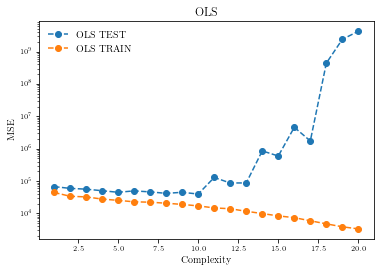

In [3]:
degree_values = np.arange(1,max_degree+1)
plt.semilogy(degree_values, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degree_values, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and ther

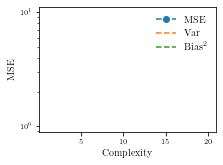

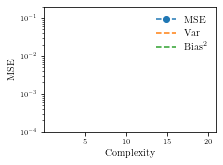

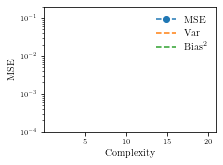

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ols_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)
plt.tight_layout()

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


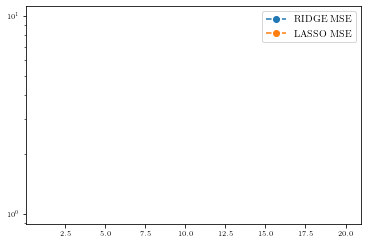

In [5]:
#plt.semilogy(degree_values, ols_boot_mse,"o--",label="OLS MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.legend()

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  after removing the cwd from sys.path.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_lau

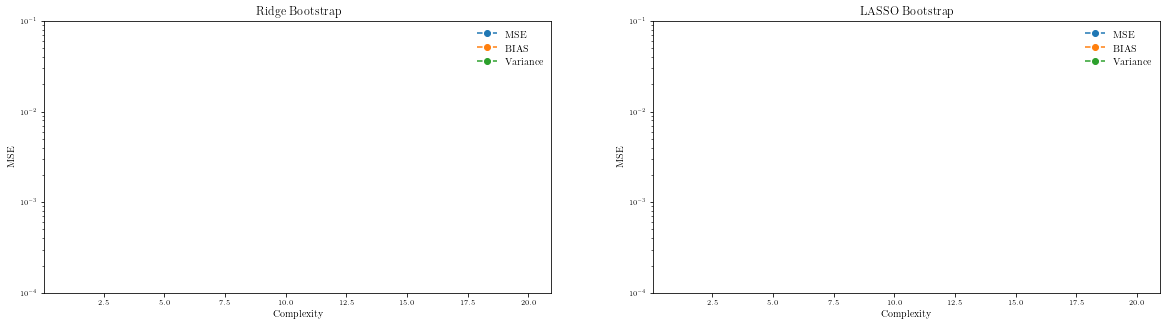

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

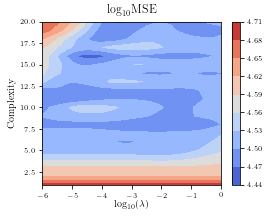

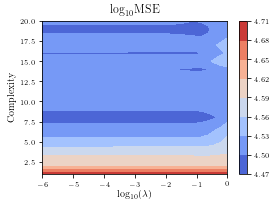

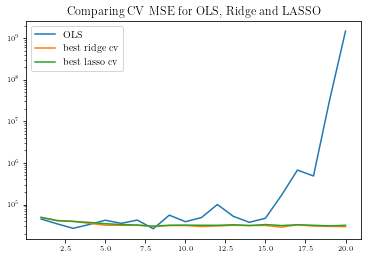

In [7]:
# CONTOUR PLOTS

# RIDGE
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(ridge_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")


# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(lasso_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")
plt.tight_layout()

# CV MSE for OLS, Ridge and LASSO:
plt.figure()
plt.semilogy(degree_values, ols_cv_mse, label ='OLS')
plt.semilogy(degree_values, best_ridge_mse, label="best ridge cv")
plt.semilogy(degree_values, best_lasso_mse, label="best lasso cv")
plt.legend()
plt.title('Comparing CV MSE for OLS, Ridge and LASSO')
plt.show()

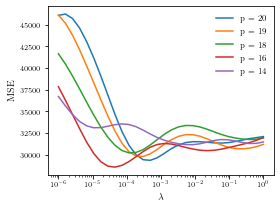

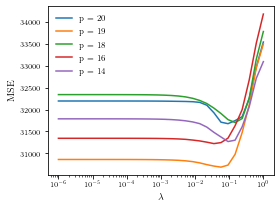

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')


# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:10: User

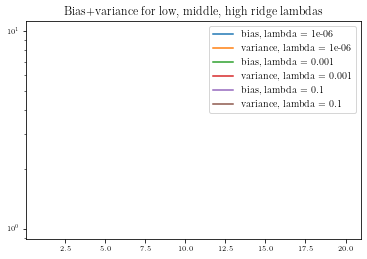

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Data has no positive values

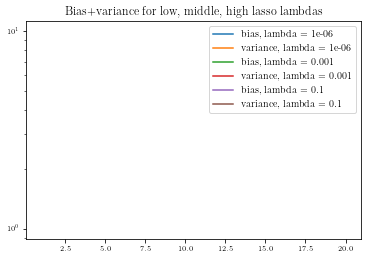

In [9]:
plt.figure()
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high ridge lambdas")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high lasso lambdas")
plt.legend()
plt.show()

In [10]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 6.21016942e-01 5.73615251e-02 8.53167852e-03
 5.29831691e-03 7.88046282e-04 8.53167852e-03 8.53167852e-03
 2.21221629e-02 1.00000000e-06 4.17531894e-06 2.80721620e-05
 1.08263673e-05 8.53167852e-03 2.80721620e-05 4.52035366e-05
 2.39502662e-01 1.17210230e-04 3.03919538e-04 4.89390092e-04]
[1.00000000e-06 3.85662042e-01 6.21016942e-01 1.00000000e-06
 5.29831691e-03 8.53167852e-03 1.00000000e-06 1.00000000e-06
 1.37382380e-02 1.00000000e-06 3.29034456e-03 1.00000000e-06
 9.23670857e-02 9.23670857e-02 9.23670857e-02 3.56224789e-02
 9.23670857e-02 1.48735211e-01 5.73615251e-02 9.23670857e-02]


In [19]:
spacing = 100 # Try 100, and try 40
degree = 14 #Try what seems best from above
ridge_lambda = 1e-2 # Ditto
lasso_lambda = 1e-1 # Ditto
np.random.seed(218)
# Setting up the terrain data:
# Note structure! X-coordinates are on the rows of terrain_data
# Point_selection.flatten() moves most rapidly over the x-coordinates
# Meshgrids flattened also move most rapidly over the x-coordinates. Thus
# this should make z(x,y).reshape(length_y,length_x) be consistent with terrain_data
terrain_data = imread("../../datafiles/SRTM_data_Norway_1.tif")
point_selection = terrain_data[:1801:spacing, :1801:spacing]  # Make quadratic and downsample
x_terrain_selection = np.linspace(0, 1, point_selection.shape[1])
y_terrain_selection = np.linspace(0, 1, point_selection.shape[0])
X_coord_selection, Y_coord_selection = np.meshgrid(x_terrain_selection, y_terrain_selection)
z_terrain_selection = point_selection.flatten()  # the response values
x_terrain_selection_flat = X_coord_selection.flatten()  # the first degree feature variables
y_terrain_selection_flat = Y_coord_selection.flatten()  # the first degree feature variables

x = x_terrain_selection_flat
y = y_terrain_selection_flat
z = z_terrain_selection

# Centering
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

x_plot = np.linspace(0, 1, 1801)
y_plot = np.linspace(0, 1, 1801)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]
# Ground truth

z_true = terrain_data[:1801, :1801]

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(-1, 1801)

# Ridge
betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(-1, 1801)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(-1, 1801)


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1975398.148164617, tolerance: 2576.4506515235457
  positive)


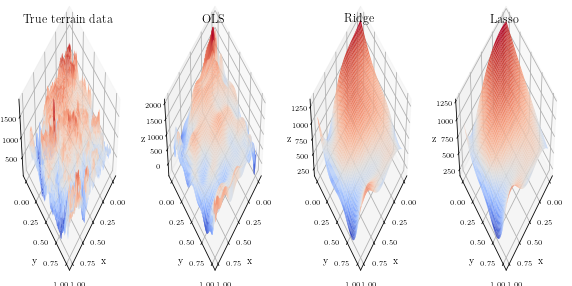

In [20]:
fig = plt.figure(figsize=(10,5))

# Plot the true terrain data
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("True terrain data")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_true, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)

ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)

ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45, elev=60)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)

plt.show()

